In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [20]:
hipp_train = pd.read_csv('train_radiomics_hipocamp.csv')
hipp_test = pd.read_csv('test_radiomics_hipocamp.csv')
df = pd.read_csv('train_radiomics_hipocamp.csv')

#hipp_train.head()
df.head()


,ID,Image,Mask,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,diagnostics_Versions_PyWavelet,diagnostics_Versions_Python,diagnostics_Configuration_Settings,diagnostics_Configuration_EnabledImageTypes,...,lbp-3D-k_glszm_ZonePercentage,lbp-3D-k_glszm_ZoneVariance,lbp-3D-k_ngtdm_Busyness,lbp-3D-k_ngtdm_Coarseness,lbp-3D-k_ngtdm_Complexity,lbp-3D-k_ngtdm_Contrast,lbp-3D-k_ngtdm_Strength,Sex,Age,Transition
0,006_S_0681,/notebooks/disk2/DS2_FreeSurfer/ADNI_006_S_068...,/notebooks/disk2/DS2_FreeSurfer/ADNI_006_S_068...,2.2.0,1.18.5,1.2.4,1.1.1,3.7.7,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'Wavelet': {}, 'LoG': {'sigma...",...,0.007881,345733.167092,479.414935,0.001538,0.183049,0.017044,0.001581,0,77.1,CN-CN
1,941_S_1203,/notebooks/disk2/DS2_FreeSurfer/ADNI_941_S_120...,/notebooks/disk2/DS2_FreeSurfer/ADNI_941_S_120...,2.2.0,1.18.5,1.2.4,1.1.1,3.7.7,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'Wavelet': {}, 'LoG': {'sigma...",...,0.013112,244310.331892,378.001763,0.001761,0.146021,0.010782,0.001813,1,83.4,CN-CN
2,011_S_0003,/notebooks/disk2/DS2_FreeSurfer/ADNI_011_S_000...,/notebooks/disk2/DS2_FreeSurfer/ADNI_011_S_000...,2.2.0,1.18.5,1.2.4,1.1.1,3.7.7,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'Wavelet': {}, 'LoG': {'sigma...",...,0.011331,222776.529605,497.261162,0.001567,0.190309,0.019644,0.001596,1,81.3,AD-AD
3,057_S_0779,/notebooks/disk2/DS2_FreeSurfer/ADNI_057_S_077...,/notebooks/disk2/DS2_FreeSurfer/ADNI_057_S_077...,2.2.0,1.18.5,1.2.4,1.1.1,3.7.7,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'Wavelet': {}, 'LoG': {'sigma...",...,0.012197,280222.663268,406.837667,0.001629,0.148247,0.010824,0.001677,1,79.6,CN-MCI
4,033_S_0920,/notebooks/disk2/DS2_FreeSurfer/ADNI_033_S_092...,/notebooks/disk2/DS2_FreeSurfer/ADNI_033_S_092...,2.2.0,1.18.5,1.2.4,1.1.1,3.7.7,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'Wavelet': {}, 'LoG': {'sigma...",...,0.010859,216779.591479,368.838125,0.001912,0.174701,0.014793,0.001979,0,80.1,CN-CN


In [ ]:
print("Este dataset tem {} colunas e {} linhas".format(df.shape[1],df.shape[0]))
df.describe()


In [ ]:
df.info()

In [5]:
df = df.dropna(axis=1, how='all')


In [ ]:
print("Este dataset tem {} colunas e {} linhas".format(df.shape[1],df.shape[0]))


In [ ]:
df.nunique()

- Verificamos que temos alguns features que têm sempre o mesmo valor tal como diagnostics_Versions_PyRadiomics que não é relevante para o estudo do modelo


In [ ]:
print(df.isna().sum())

In [ ]:
#Ver todas as colunas
columns_list = df.columns.tolist()
print(columns_list)

In [21]:

#Atençao isto é só para testar o split, depois temos de fazer o split com o dataset todo
colunas_remover = ['ID','Image', 'diagnostics_Image-original_Hash', 'diagnostics_Mask-original_Hash',
                   'diagnostics_Mask-original_BoundingBox', 'diagnostics_Mask-original_CenterOfMassIndex',
                   'diagnostics_Mask-original_CenterOfMass', 'Mask']
df = df.drop(columns=colunas_remover, errors='ignore').loc[:, df.nunique() > 1]
hipp_test = hipp_test.drop(columns=colunas_remover, errors='ignore').loc[:, hipp_test.nunique() > 1]

In [22]:
def replace_outliers_with_closest(df):
    """
    Replace outliers in numeric columns of a DataFrame with the closest non-outlier value.
    
    Parameters:
    df (pandas.DataFrame): Input DataFrame.

    Returns:
    pandas.DataFrame: DataFrame with outliers replaced.
    """
    for column in df.select_dtypes(include=['number']).columns:
        data = df[column]
        
        # Calculate IQR and outlier bounds
        q1 = data.quantile(0.25)
        q3 = data.quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        # Replace outliers with the closest non-outlier value
        df[column] = data.apply(
            lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x)
        )

    return df

print("Original DataFrame:")
print(df)

# Apply the function
df= replace_outliers_with_closest(df)

print("\nDataFrame After Replacing Outliers:")
print(df)


Original DataFrame:
     diagnostics_Image-original_Mean  diagnostics_Image-original_Maximum  \
0                           5.848123                                 178   
1                           5.238834                                 190   
2                           6.816667                                 155   
3                           6.445162                                 171   
4                           5.568269                                 150   
..                               ...                                 ...   
300                         6.268191                                 203   
301                         4.846839                                 181   
302                         6.562003                                 164   
303                         7.583210                                 135   
304                         5.329772                                 180   

     diagnostics_Mask-original_VoxelNum  original_shape_Elongation 

In [ ]:
from sklearn.cluster import KMeans
import pandas as pd

# Apply KMeans clustering to features (columns)
kmeans = KMeans(n_clusters=5, random_state=42)
feature_clusters = kmeans.fit_predict(df.drop(columns=['Transition']).T)

# Assign cluster labels to features
feature_labels = pd.DataFrame({
    'Feature': df.drop(columns=['Transition']).columns,
    'Cluster': feature_clusters
})
print(feature_labels.sort_values('Cluster'))

# Visualize feature clustering as a heatmap
import seaborn as sns
sns.heatmap(
    df.drop(columns=['Transition']).corr(),
    cmap='coolwarm',
    annot=False,
    cbar=True
)
plt.title('Heatmap of Feature Correlations')
plt.show()


C:\Users\Diogo\AppData\Local\Temp\ipykernel_22376\975425435.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['AgeRange'] = pd.cut(df['Age'], bins=bins, labels=labels, right=True)
C:\Users\Diogo\AppData\Local\Temp\ipykernel_22376\975425435.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=age_group_counts.index, y=age_group_counts.values, palette='viridis')


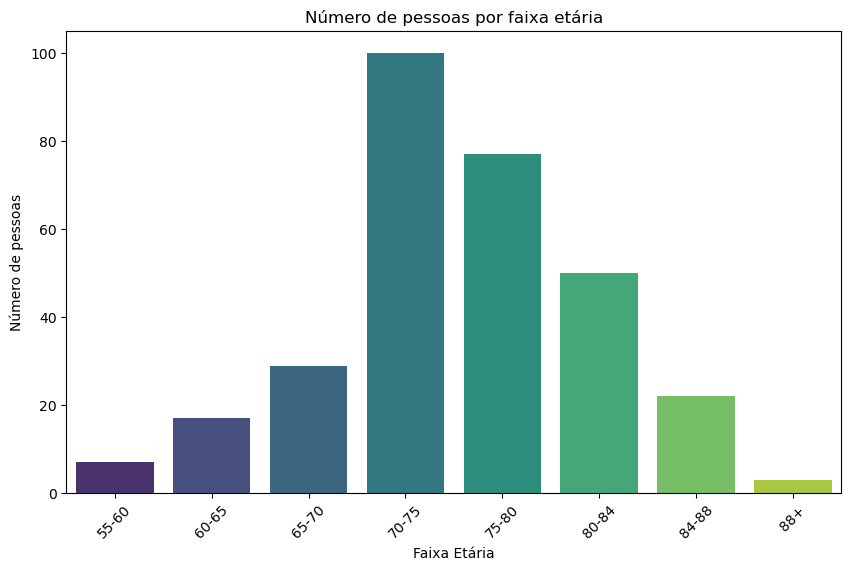

In [23]:
#Numero de pessoas por idade

bins = [55, 60, 65, 70, 75, 80, 84, 88, np.inf]  # Define the edges of the bins
labels = ['55-60', '60-65', '65-70', '70-75', '75-80', '80-84', '84-88', '88+']  # Labels for the bins

# Create the AgeRange column using pd.cut
df['AgeRange'] = pd.cut(df['Age'], bins=bins, labels=labels, right=True)
hipp_test['AgeRange'] = pd.cut(hipp_test['Age'], bins=bins, labels=labels, right=True)

# Count the number of people in each bin
age_group_counts = df['AgeRange'].value_counts().sort_index()

# Plot the data
plt.figure(figsize=(10, 6))
sns.barplot(x=age_group_counts.index, y=age_group_counts.values, palette='viridis')
plt.title('Número de pessoas por faixa etária')
plt.xlabel('Faixa Etária')
plt.ylabel('Número de pessoas')
plt.xticks(rotation=45)
plt.show()


In [24]:
for label in labels:
    df[label] = (df['AgeRange'] == label).astype(int)
    hipp_test[label] = (hipp_test['AgeRange'] == label).astype(int)

# Remover a coluna 'Age' e 'Age_Bin' do conjunto de treino e teste
df.drop(columns=['Age', 'AgeRange'], inplace=True)
hipp_test.drop(columns=['Age', 'AgeRange'], inplace=True)

C:\Users\Diogo\AppData\Local\Temp\ipykernel_22376\178898505.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[label] = (df['AgeRange'] == label).astype(int)
C:\Users\Diogo\AppData\Local\Temp\ipykernel_22376\178898505.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[label] = (df['AgeRange'] == label).astype(int)
C:\Users\Diogo\AppData\Local\Temp\ipykernel_22376\178898505.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

In [25]:
df.drop(columns=['Age'], inplace=True)
hipp_test.drop(columns=['Age'], inplace=True)
columns_to_drop = df.select_dtypes(include=['object']).columns
columns_to_drop = columns_to_drop.drop('Transition')

df.head()

KeyError: "['Age'] not found in axis"

In [26]:
# Align hipp_test with df
missing_columns = set(df.columns) - set(hipp_test.columns)
extra_columns = set(hipp_test.columns) - set(df.columns)

# Add missing columns with default value (e.g., 0 or None)
for col in missing_columns:
    hipp_test[col] = 0  # Default value can be changed to None or other as needed

# Remove extra columns
hipp_test = hipp_test.drop(columns=extra_columns, errors='ignore')

# Reorder columns to match df
hipp_test = hipp_test[df.columns]

# Verify
print("Columns in hipp_test now match df:", hipp_test.columns.equals(df.columns))


Columns in hipp_test now match df: True


In [27]:
df = pd.get_dummies(df, columns=['AgeRange'], drop_first=True)
hipp_test = pd.get_dummies(hipp_test, columns=['AgeRange'], drop_first=True)
df.head()


KeyError: "None of [Index(['AgeRange'], dtype='object')] are in the [columns]"

In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
import shap
import time

# Mapear a coluna 'Transition' para valores numéricos
mapping = {
    'CN-CN': 0,  # Estado Normal
    'CN-MCI': 1,  # Estado Intermediário
    'MCI-MCI': 2,  # Estado Intermediário
    'MCI-AD': 3,  # Demência
    'AD-AD': 4    # Demência
}
df['Transition'] = df['Transition'].map(mapping)

# Preparar dados para treinamento
X_train = df.drop(['Transition'], axis=1)
y_train = df['Transition']

# Dividir o conjunto de treinamento em treino e teste
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train, y_train, test_size=0.2, random_state=2022)

# Apply pd.get_dummies to convert categorical features to numeric
X_train_split = pd.get_dummies(X_train_split, drop_first=True)
X_test_split = pd.get_dummies(X_test_split, drop_first=True)

# Ensure all columns are numeric
X_train_split = X_train_split.apply(pd.to_numeric, errors='coerce')
X_test_split = X_test_split.apply(pd.to_numeric, errors='coerce')

# Handle missing data (if any)
X_train_split = X_train_split.fillna(0)
X_test_split = X_test_split.fillna(0)

# Check that all columns are numeric
print(X_train_split.dtypes)

# Definir os parâmetros do XGBClassifier
best_params = {
    'booster': 'dart',
    'colsample_bytree': 0.6,
    'gamma': 0.1,
    'learning_rate': 0.2,
    'max_delta_step': 1,
    'max_depth': 3,
    'min_child_weight': 3,
    'n_estimators': 97,
    'reg_alpha': 0.1,
    'reg_lambda': 100,
    'subsample': 0.6,
    'random_state': 2022,
    'use_label_encoder': False,
    'eval_metric': 'mlogloss'
}

# Initialize the XGBClassifier with the best parameters
best_xgb_model = XGBClassifier(**best_params)

# Train the model
start_time = time.time()
best_xgb_model.fit(X_train_split, y_train_split)
elapsed_time = time.time() - start_time

print(f"Tempo para treinar o modelo: {elapsed_time:.3f} segundos")

# Make predictions
predictions = best_xgb_model.predict(X_test_split)

# Print the classification report
print(classification_report(y_test_split, predictions, target_names=list(mapping.keys())))

# SHAP Feature Importance
explainer = shap.Explainer(best_xgb_model, X_train_split)
shap_values = explainer(X_train_split)

# Ensure SHAP values align with features
print("SHAP values shape:", shap_values.values.shape)
print("Number of features in X_train_split:", X_train_split.shape[1])

# Aggregate SHAP values
if len(shap_values.values.shape) == 3:  # Multiclass model
    mean_shap_values = np.abs(shap_values.values).mean(axis=(0, 1))
else:  # Single-class or binary model
    mean_shap_values = np.abs(shap_values.values).mean(axis=0)

# Verify alignment
print("Aggregated SHAP values length:", len(mean_shap_values))
print("Number of features:", len(X_train_split.columns))

# Create a DataFrame for SHAP importances
shap_importances = pd.DataFrame({
    'Feature': X_train_split.columns,
    'Importance': mean_shap_values
}).sort_values(by='Importance', ascending=False)

print("\nSHAP Feature Importances:")
print(shap_importances)

# Filter features with Importance > 0
important_features = shap_importances[shap_importances['Importance'] > 0]['Feature'].tolist()

# Filter training and testing data
X_train_filtered = X_train_split[important_features]
X_test_filtered = X_test_split[important_features]

# Retrain the best model on filtered features
best_xgb_model.fit(X_train_filtered, y_train_split)
predictions = best_xgb_model.predict(X_test_filtered)

# Exibir o classification report
print(classification_report(y_test_split, predictions, target_names=list(mapping.keys())))

# Fazer previsões no conjunto de teste final com o melhor modelo
X_test = hipp_test.drop(columns=['ID'], errors='ignore')
X_test = X_test[important_features]  # Use only important features
predictions_mapped = pd.Series(best_xgb_model.predict(X_test)).map({v: k for k, v in mapping.items()})

# Criar o DataFrame de submissão
submission_df = pd.DataFrame({
    'RowId': range(1, len(predictions_mapped) + 1),
    'Result': predictions_mapped
})

# Verificação de número de previsões e salvar submissão
if len(submission_df) < 100:
    print("Aviso: O conjunto de teste contém menos de 100 entradas. Submissão terá apenas", len(submission_df), "previsões.")
else:
    print("Número total de previsões:", len(submission_df))

submission_df.to_csv('XGBNewFeature.csv', index=False)
print("Submissão salva com sucesso com exatamente", len(submission_df), "previsões.")


diagnostics_Image-original_Mean       float64
diagnostics_Image-original_Maximum    float64
diagnostics_Mask-original_VoxelNum    float64
original_shape_Elongation             float64
original_shape_Flatness               float64
                                       ...   
70-75                                   int32
75-80                                   int32
80-84                                   int32
84-88                                   int32
88+                                     int32
Length: 2020, dtype: object


c:\Users\Diogo\miniconda3\envs\Ambiente\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:59:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Tempo para treinar o modelo: 106.232 segundos


c:\Users\Diogo\miniconda3\envs\Ambiente\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Diogo\miniconda3\envs\Ambiente\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Diogo\miniconda3\envs\Ambiente\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

              precision    recall  f1-score   support

       CN-CN       0.46      0.76      0.58        17
      CN-MCI       0.00      0.00      0.00         2
     MCI-MCI       0.33      0.12      0.18        16
      MCI-AD       0.35      0.46      0.40        13
       AD-AD       0.70      0.54      0.61        13

    accuracy                           0.46        61
   macro avg       0.37      0.38      0.35        61
weighted avg       0.44      0.46      0.42        61

shap_values.values shape: (244, 2020, 5)
Number of features in X_train_split: 2020


ValueError: All arrays must be of the same length

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Map labels to numeric values
mapping = {'CN-CN': 1, 'CN-MCI': 2, 'MCI-MCI': 3, 'MCI-AD': 4, 'AD-AD': 5}
df['Transition'] = df['Transition'].map(mapping)

# Separate features and labels
X = df.drop(['Transition'], axis=1)
y = df['Transition']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Impute missing values (if necessary)
imputer = SimpleImputer(strategy="mean")
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X.columns)

# Scale the data
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

# Train the SVC model
param_grid = {
    'C': [0.1, 1, 10, 100],           # Regularization strength
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],  # Kernel coefficient for RBF
    'kernel': ['rbf', 'linear', 'poly']  # Kernel types
}

# Initialize GridSearchCV
grid_search = GridSearchCV(SVC(random_state=42), param_grid, scoring='accuracy', cv=5, verbose=2, n_jobs=-1)

# Perform GridSearchCV
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Train the best model on the training data
best_svc = grid_search.best_estimator_

# Evaluate the model
y_pred = best_svc.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(mapping.keys()), yticklabels=list(mapping.keys()))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Prepare the test dataset (hipp_test)
X_test_final = hipp_test.drop(columns=['ID'], errors='ignore')

# Check for missing values in hipp_test
print("Valores nulos em X_test:")
print(X_test_final.isnull().sum())

# Impute missing values for the final test set
X_test_final = pd.DataFrame(imputer.transform(X_test_final), columns=X_test.columns)

# Scale the final test data
X_test_final = pd.DataFrame(scaler.transform(X_test_final), columns=X_test.columns)



# Predict and map results
predictions = best_svc.predict(X_test_final)
inverse_mapping = {1: 'CN-CN', 2: 'CN-MCI', 3: 'MCI-MCI', 4: 'MCI-AD', 5: 'AD-AD'}
predictions_mapped = pd.Series(predictions).map(inverse_mapping)

# Create submission file
submission_df = pd.DataFrame({
    'RowId': range(1, len(predictions_mapped) + 1),
    'Result': predictions_mapped
})

if len(submission_df) < 100:
    print("Aviso: O conjunto de teste contém menos de 100 entradas. Submissão terá apenas", len(submission_df), "previsões.")
else:
    print("Número total de previsões:", len(submission_df))

submission_df.to_csv('SVC.csv', index=False)
print("Submissão salva com sucesso com exatamente", len(submission_df), "previsões.")


original_glszm_LargeAreaEmphasis - Reflects larger homogeneous zones. Decreases may indicate fragmentation.
Ou seja isto indica fragmentação vamos ver este atributo

In [ ]:
#Feature Importance atraves do SHAP values remover os que sao 0
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split


mapping = {
    'CN-CN': 1,  # Estado Normal
    'CN-MCI': 2,  # Estado Intermediário
    'MCI-MCI': 3,  # Estado Intermediário
    'MCI-AD': 4,  # Demência
    'AD-AD': 5    # Demência
}
df['Transition'] = df['Transition'].map(mapping)

# Preparar dados para treinamento
X_train = df.drop(['Transition'], axis=1)
y_train = hipp_test(['Transition'], axis=1)

# Dividir o conjunto de treinamento em treino e teste
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train, y_train, test_size=0.2, random_state=2022)

X_train_split.head()
y_train_split.head()

# Treinar o modelo
pg_model = RandomForestClassifier(bootstrap=True, max_depth=10, random_state=2022)
pg_model.fit(X_train_split, y_train_split)

# Fazer previsões no conjunto de teste
predictions = pg_model.predict(X_test_split)

# Exibir o classification report
print(classification_report(y_test_split, predictions, target_names=list(mapping.keys())))

#Medir o MDI
start_time = time.time()

mdi_importances = pd.Series(pg_model.feature_importances_, index=X_test_split.columns)

elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")
print("Feature importances using MDI:\n", mdi_importances )
mdi_importances.to_csv("mdi_importances.csv", index=True)
#Implementação do permutation importance

result = permutation_importance(
    pg_model, X_test_split, y_test_split, n_repeats=10, random_state=42, n_jobs=2
)

# Ordenar os índices de importâncias em ordem crescente
sorted_importances_idx = result.importances_mean.argsort()

# Criar um DataFrame com as importâncias, ordenado
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X_test_split.columns[sorted_importances_idx],
)

important_features = mdi_importances[mdi_importances != 0].index

df = df[important_features]


df.head()


In [ ]:

# Agrupa os dados por faixa etária e calcula a média
#Só tens de mudar o original_glszm_LargeAreaEmphasis para a feature que queres ver, o resto é igual
range_means = df.groupby('AgeRange')['original_glszm_LargeAreaEmphasis'].median()

# Basicamente calcula a média do valor da feature para cada faixa etária

# Exibe os resultados
print(range_means)

# Plotando os resultados
plt.figure(figsize=(10, 6))
sns.barplot(x=range_means.index, y=range_means.values, palette='viridis')
plt.title('Média de valores por faixa de idade')
plt.xlabel('Faixa Etária')
plt.ylabel('Média de Valores original_glszm_LargeAreaEmphasis')
plt.xticks(rotation=45)
plt.show()


In [ ]:
#one hot encoding using OneHotEncoder of Scikit-Learn

import pandas as pd
from sklearn.preprocessing import OneHotEncoder

categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
encoder = OneHotEncoder(sparse_output=False)

# Apply one-hot encoding to the categorical columns
one_hot_encoded = encoder.fit_transform(df[categorical_columns])

#Create a DataFrame with the one-hot encoded columns
#We use get_feature_names_out() to get the column names for the encoded data
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))

# Concatenate the one-hot encoded dataframe with the original dataframe
df_encoded = pd.concat([df, one_hot_df], axis=1)

# Drop the original categorical columns
df_encoded = df_encoded.drop(categorical_columns, axis=1)
print(f"Encoded Employee data : \n{df_encoded}")

In [ ]:
# Display the first few rows of the numerical DataFrame
df_encoded.head()

In [ ]:
# import matplotlib.pyplot as plt

# plt.matshow(df_encoded.corr())
# plt.show()

# Unique Transition categories
transitions = df['Transition'].unique()

# Plotting correlation matrices for each Transition
fig, axes = plt.subplots(nrows=1, ncols=len(transitions), figsize=(5 * len(transitions), 5))

for i, transition in enumerate(transitions):
    # Subset data for the specific Transition
    subset = df[df['Transition'] == transition].drop('Transition', axis=1)
    
    # Compute correlation matrix
    corr = subset.corr()
    
    # Plot the heatmap
    ax = axes[i] if len(transitions) > 1 else axes  # Handle single subplot case
    cax = ax.matshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
    ax.set_title(transition, y=1.2, fontsize=12)
    
    # Add variable labels
    ax.set_xticks(range(subset.shape[1]))
    ax.set_xticklabels(subset.columns, rotation=45, ha='left', fontsize=10)
    ax.set_yticks(range(subset.shape[1]))
    ax.set_yticklabels(subset.columns, fontsize=10)

# Add a colorbar to the right of the last subplot
fig.colorbar(cax, ax=axes.ravel().tolist(), shrink=0.8)
plt.suptitle('Correlation Matrices by Transition', fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import random

def relacao_entre_atributos(df):
    sns.pairplot(df)
    plt.show()
    
def relation_with_Transition(df, categorical_vars=[], numerical_vars=[],binary_vars=[], sample_size=1000):
    # Take a random sample of the data
    df_sample = df.sample(min(sample_size, len(df)))
    
    # Plot bar plots for categorical and binary variables
    for var in categorical_vars + binary_vars:
        plt.figure(figsize=(10, 6))
        sns.countplot(x=var, hue='Transition', data=df_sample)
        plt.title(f'Relação com Transition- {var}')
        plt.show()

    # Scatter plots for numerical variables
    n_cols = 2
    n_lines = (len(numerical_vars) - 1) // n_cols + 1
    
    fig, axs = plt.subplots(n_lines, n_cols, figsize=(12, 4 * n_lines))
    
    for i, var in enumerate(numerical_vars):
        sns.scatterplot(data=df_sample, x='Transition', y=var, ax=axs[i // n_cols, i % n_cols])
        axs[i // n_cols, i % n_cols].set_title(f'Relação com Transition - {var}')

    # Ajustar layout
    plt.tight_layout()
    plt.show()

# Divisao das variáveis de acordo com as categorias
categorical_vars = ['Transition']
numerical_vars = ['diagnostics_Image-original_Mean', 'original_glcm_Contrast', 'original_firstorder_Mean', 'original_glcm_Correlation']
binary_vars = ['Sex']

# Chamar a função para criar os gráficos de dispersão e barras
relation_with_Transition(df, categorical_vars=categorical_vars, numerical_vars=numerical_vars, binary_vars=binary_vars ,sample_size=1000)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

def distribuicao_dos_atributos(dataframe):
    columns_number = 2014
    lines_number = 304
    fig, axs = plt.subplots(lines_number,columns_number,figsize=(30,20))
    fig.suptitle('Histogramas')
    columns = list(dataframe.select_dtypes(include=np.number).columns)
    i = 0; j = 0
    for elem in columns:
        plt.figure(figsize = (10,8))
        sns.histplot(x = dataframe[elem], data=dataframe, ax=axs[i,j], kde=True)
        j = j + 1
        if(j == columns_number):
            i=i+1
            j = 0

distribuicao_dos_atributos(df)

In [ ]:
counts = df.groupby(['AgeRange', 'Transition']).size().unstack(fill_value=0)
print(counts)

plt.figure(figsize=(12, 8))
sns.heatmap(counts, annot=True, fmt='d', cmap='viridis', cbar_kws={'label': 'Count'})
plt.title('Heatmap of Transition Counts by Age Range')
plt.xlabel('Transition')
plt.ylabel('Age Range')
plt.tight_layout()
plt.show()

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Distribuição de Features por Faixa Etária', fontsize=16)

# Plot each variable on a separate subplot
sns.boxplot(x='Transition', y='original_glszm_LargeAreaEmphasis', data=df, ax=axs[0, 0], palette='viridis')
axs[0, 0].set_title('Distribuição da feature original_glszm_LargeAreaEmphasis')

sns.boxplot(x='Transition', y='original_shape_MeshVolume', data=df, ax=axs[0, 1], palette='viridis')
axs[0, 1].set_title('Distribuição da feature original_shape_MeshVolume')

sns.boxplot(x='Transition', y='original_shape_SurfaceVolumeRatio', data=df, ax=axs[1, 0], palette='viridis')
axs[1, 0].set_title('Distribuição da feature original_shape_SurfaceVolumeRatio')

sns.boxplot(x='Transition', y='original_firstorder_Mean', data=df, ax=axs[1, 1], palette='viridis')
axs[1, 1].set_title('Distribuição da feature original_firstorder_Mean')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])  # To make space for the suptitle
plt.show()

In [ ]:
#Pensar em implementar o PCA para reduzir a dimensionalidade, ver quais as features mais importantes e depois fazer o split


In [ ]:
hipp_train['Transition'] = pd.factorize(hipp_train['Transition'])[0] + 1
#Torna o label de categorico para numerico
hipp_train.describe()

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.calibration import LabelEncoder
import xgboost as xgb

#Atençao isto é só para testar o split, depois temos de fazer o split com o dataset todo
colunas_remover = ['Image', 'diagnostics_Image-original_Hash', 'diagnostics_Mask-original_Hash',
                   'diagnostics_Mask-original_BoundingBox', 'diagnostics_Mask-original_CenterOfMassIndex',
                   'diagnostics_Mask-original_CenterOfMass', 'Mask']
hipp_train = hipp_train.drop(columns=colunas_remover, errors='ignore').loc[:, hipp_train.nunique() > 1]
hipp_test = hipp_test.drop(columns=colunas_remover, errors='ignore').loc[:, hipp_test.nunique() > 1]


X = hipp_train.drop(['Transition', 'ID'], axis=1)
y = hipp_train['Transition']

# label_encoder = LabelEncoder()
# y= label_encoder.fit_transform(y)
# Dividir o conjunto de treino em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2021)

## Ver a learning curve para perceber a quantos epochs causa overfitting por exemplo
# Temos de testar como temos aqui



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Generate synthetic data
np.random.seed(0)
x = np.linspace(0, 10, 100)
y = np.sin(x) + np.random.normal(scale=0.2, size=x.shape)

# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

# Fit polynomial regression models of different degrees
degrees = [1, 3, 10, 20]
train_errors = []
test_errors = []

for degree in degrees:
    poly_features = PolynomialFeatures(degree=degree)
    x_poly_train = poly_features.fit_transform(x_train[:, np.newaxis])
    x_poly_test = poly_features.transform(x_test[:, np.newaxis])
    
    model = LinearRegression()
    model.fit(x_poly_train, y_train)
    
    train_predictions = model.predict(x_poly_train)
    test_predictions = model.predict(x_poly_test)
    
    train_errors.append(mean_squared_error(y_train, train_predictions))
    test_errors.append(mean_squared_error(y_test, test_predictions))

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(degrees, train_errors, label='Train Error', marker='o')
plt.plot(degrees, test_errors, label='Test Error', marker='o')
plt.title('Learning Curves')
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Squared Error')
plt.xticks(degrees)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#Logistic Regression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report



model = LogisticRegression(multi_class='ovr', solver='liblinear', random_state=2021)

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Detailed classification report
print(classification_report(y_test, y_pred))

if len(y_pred) < 100:
    additional_predictions = np.random.choice(y_pred, 100 - len(y_pred), replace=True)
    y_pred = np.concatenate([y_pred, additional_predictions])

# Create the DataFrame with exactly 100 predictions
df = pd.DataFrame({
    "RowId": range(1, 101),  # RowId starting from 1 to 100
    "Result": y_pred[:100]   # Ensure 100 predictions by taking only the first 100
})
# Save the DataFrame to a CSV file
df.to_csv("predictions.csv", index=False)

if len(df) < 100:
    print("Aviso: O conjunto de teste contém menos de 100 entradas. Submissão terá apenas", len(df), "previsões.")
else:
    print("Número total de previsões:", len(df))

print("Predictions saved to 'predictions.csv'")


In [ ]:
#Decision Tree
from sklearn.calibration import LabelEncoder
import xgboost as xgb

from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report


svm_model = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=1.0, gamma='scale', random_state=2021))

# Train the model
svm_model.fit(X_train, y_train)

# Predict on the test set
y_pred = svm_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Detailed classification report
print(classification_report(y_test, y_pred))

if len(y_pred) < 100:
    additional_predictions = np.random.choice(y_pred, 100 - len(y_pred), replace=True)
    y_pred = np.concatenate([y_pred, additional_predictions])

# Create the DataFrame with exactly 100 predictions
df = pd.DataFrame({
    "RowId": range(1, 101),  # RowId starting from 1 to 100
    "Result": y_pred[:100]   # Ensure 100 predictions by taking only the first 100
})
# Save the DataFrame to a CSV file
df.to_csv("predictions.csv", index=False)

if len(df) < 100:
    print("Aviso: O conjunto de teste contém menos de 100 entradas. Submissão terá apenas", len(df), "previsões.")
else:
    print("Número total de previsões:", len(df))

print("Predictions saved to 'predictions.csv'")

In [ ]:
# Separate features (X) and target labels (y) USAR ISTO PARA O MODELO DE MACHINE LEARNING
X = hipp_train.drop(columns=['ID','Label'])  # Replace 'Label' with the actual column name for your target
y = hipp_train['Label']                 # Target variable in the training set

X_test = hipp_test.drop(columns=['ID','Label'])    # Features only for testing
y_test = hipp_test['Label']                   # True labels for testing (for evaluation only)

#X_train contains the features (input variables) for training the model.
#y_train contains the target labels (output) that correspond to each row in X_train.
#X_test contains the features for testing how well the model performs on unseen data.
#y_test contains the true labels for the test data, which you use to evaluate the model’s predictions.

In [ ]:
df.dtypes
df.info()
df.describe()


In [ ]:
df.head()

In [ ]:
df.isna().any()
print(df.isna().sum())

In [ ]:
print(df.duplicated().sum())

In [ ]:
# print(df['Target'].value_counts())
df['diagnostics_Image-original_Mean'].hist()
plt.title('Histogram of diagnostics_Image-original_Mean')
plt.xlabel('Mean Value')
plt.ylabel('Frequency')
plt.show()

In [ ]:
sns.heatmap(df.isnull(),yticklabels=False ,cbar=False, cmap='viridis')
plt.show()

In [ ]:
sex_counts = df['Sex'].value_counts()
print(sex_counts)

# secalhar o 1 é mulheres e o 0 é homens tenho que ver isto melhor

In [ ]:
#TEMOS DE TORNAR OS OBJETOS EM VALORES NÙMERICOS PARA PUDERMOS UTILIZAR OS MODELOS DE MACHINE LEARNING
from sklearn.preprocessing import OneHotEncoder


categorical_columns = df.select_dtypes(include=['object']).columns.tolist()

#Initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

# Apply one-hot encoding to the categorical columns
one_hot_encoded = encoder.fit_transform(df[categorical_columns])

#Create a DataFrame with the one-hot encoded columns
#We use get_feature_names_out() to get the column names for the encoded data
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))


print(one_hot_df.head())



In [ ]:
df_encoded = pd.concat([df, one_hot_df], axis=1)

# Drop the original categorical columns
df_encoded = df_encoded.drop(categorical_columns, axis=1)

# Display the resulting dataframe
print(f"Encoded data : \n{df_encoded}")

In [ ]:


sns.boxplot(x='diagnostics_Image-original_Maximum', y='Transition', data=df)
plt.show()

print(df)

In [ ]:
contador = 0 
for column in hipp_test.columns:
    if hipp_test[column].nunique() == 1: 
        print(f"A coluna: '{column}' tem apenas um valor único.")
        contador +=1
print(f"Colunas com valor 1:{contador}")

In [ ]:
#Verificar as colunas que tem apenas 1 valor 
contador = 0
for column in hipp_train.columns:
    if hipp_train[column].nunique() == 1: 
        print(f"A coluna: '{column}' tem apenas 1 valor único.")
        contador +=1 
print(f"Numero total de colunas de um valor: '{contador}'")

In [ ]:
hipp_train_c = hipp_train.loc[:, hipp_train.nunique() > 1]
colunas_removidas = hipp_train.columns[hipp_train.nunique() == 1]
print(f"Colunas removidas: {colunas_removidas}")

In [ ]:
#Remover os valores nunique de treino
hipp_test_c = hipp_test.loc[:, hipp_test.nunique() > 1]
colunas_removidas = hipp_test.columns[hipp_test.nunique() == 1]
print(f"As colunas que foram removidas '{colunas_removidas}'")

In [ ]:
mapping = {
    'CN-CN': 1,  # Estado Normal
    'CN-MCI': 2,  # Estado Intermediário
    'MCI-MCI': 2,  # Estado Intermediário
    'MCI-AD': 3,  # Demência
    'AD-AD': 3   # Demência
}

# Aplicar o mapeamento à coluna 'Transition'
hipp_train['Transition'] = hipp_train['Transition'].map(mapping)

# Verificar o resultado
# print(hipp_train[['Transition', 'Transition_Numeric']].head())



In [ ]:
hipp_train.head()

In [ ]:
# Separate features (X) and target labels (y) USAR ISTO PARA O MODELO DE MACHINE LEARNING
X_train = hipp_train.drop(columns=['ID','Label'])  # Replace 'Label' with the actual column name for your target
y_train = hipp_train['Label']                 # Target variable in the training set

X_test = hipp_test.drop(columns=['ID','Label'])    # Features only for testing
y_test = hipp_test['Label']                   # True labels for testing (for evaluation only)

#X_train contains the features (input variables) for training the model.
#y_train contains the target labels (output) that correspond to each row in X_train.
#X_test contains the features for testing how well the model performs on unseen data.
#y_test contains the true labels for the test data, which you use to evaluate the model’s predictions.

In [ ]:
from sklearn.model_selection import train_test_split

#Atençao isto é só para testar o split, depois temos de fazer o split com o dataset todo
colunas_remover = ['Image', 'diagnostics_Image-original_Hash', 'diagnostics_Mask-original_Hash',
                   'diagnostics_Mask-original_BoundingBox', 'diagnostics_Mask-original_CenterOfMassIndex',
                   'diagnostics_Mask-original_CenterOfMass', 'Mask']
hipp_train = hipp_train.drop(columns=colunas_remover, errors='ignore').loc[:, hipp_train.nunique() > 1]
hipp_test = hipp_test.drop(columns=colunas_remover, errors='ignore').loc[:, hipp_test.nunique() > 1]


X_train = hipp_train.drop(['Transition', 'ID'], axis=1)
y_train = hipp_train['Transition']

# Dividir o conjunto de treino em treino e teste
X_train_split, X_test, y_train_split, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=2021)

In [ ]:
X_train.head()

In [ ]:
y_train.head()

In [ ]:
# Predict on the test set
from sklearn.metrics import accuracy_score, f1_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
# Initialize the SVM classifier
clf = DecisionTreeClassifier(random_state=2021)

# Train the model on the training set
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
# could not convert string to float: '/notebooks/disk2/DS2_FreeSurfer/ADNI_006_S_0681_MR_MP-RAGE__br_raw_20060831143335593_1_S18451_I23677_generate/mri/brain.nii.gz
# Evaluate the model's performance
#accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy: {accuracy:.2f}")

f1 = f1_score(y_test, y_pred, average='weighted')

print("F1 Score:", f1)


In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

In [ ]:
import pandas as pd

# Example predictions
y_pred = ["CN-CN"] * 100  # Replace with actual predictions

# Create a DataFrame with RowId and Result columns
df = pd.DataFrame({
    "RowId": range(1, len(y_pred) + 1),  # RowId starting from 1
    "Result": y_pred                     # Model predictions
})

# Save the DataFrame to a CSV file
df.to_csv("predictions.csv", index=False)

print("Predictions saved to 'predictions.csv'")